In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
import math

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Initialize the stemmer and stop words
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\face\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the datasets
true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('Fake.csv')

# Add labels: 1 for true news, 0 for fake news
true_df['label'] = 1
fake_df['label'] = 0

# Combine the datasets
data = pd.concat([true_df, fake_df], ignore_index=True)

# Display the shape and first few rows of the data
print(f'Dataset shape: {data.shape}')
print(data.head())


Dataset shape: (44898, 5)
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


In [3]:
# Create a cleaned corpus for tokenization
corpus = []
for i in range(len(data)):
    # Remove non-alphabetical characters
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()  # Convert to lowercase
    review = review.split()  # Split into words
    
    # Stem each word and remove stopwords
    review = [ps.stem(word) for word in review if word not in stop_words]
    
    # Join the cleaned words back into a single string
    review = ' '.join(review)
    corpus.append(review)


In [4]:
# Tokenize and pad text data for LSTM
max_features = 10000  # Number of unique words to consider (vocabulary size)
max_length = 300  # Maximum sequence length

# Initialize the tokenizer and fit on the corpus
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(corpus)

# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(corpus)
X = sequence.pad_sequences(X, maxlen=max_length)

# Define labels
y = data['label'].values

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Testing set shape: {X_test.shape}, {y_test.shape}')


Training set shape: (35918, 300), (35918,)
Testing set shape: (8980, 300), (8980,)


In [5]:
# Define the LSTM model
embed_size = 100  # Size of word embeddings
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embed_size, input_length=max_length, trainable=True))
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.25, dropout=0.25))
model.add(LSTM(units=64, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


c:\Users\face\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
batch_size = 256
epochs = 20

history = model.fit(X_train, y_train, validation_split=0.3, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.8760 - loss: 0.2412 - val_accuracy: 0.9813 - val_loss: 0.0647
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9789 - loss: 0.0633 - val_accuracy: 0.9896 - val_loss: 0.0393
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9920 - loss: 0.0248 - val_accuracy: 0.9907 - val_loss: 0.0307
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9971 - loss: 0.0100 - val_accuracy: 0.9893 - val_loss: 0.0310
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9972 - loss: 0.0104 - val_accuracy: 0.9955 - val_loss: 0.0170
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.9977 - loss: 0.0052 - val_accuracy: 0.9942 - val_loss: 0.0227
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9985 - loss: 0.0058 - val_accuracy: 0.9935 - val_loss: 0.0281
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9958 - loss: 0.0150 - val_accuracy: 0.9916 - v

In [7]:
# Evaluate the model on the training set
train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1] * 100
print(f'Model accuracy on Training Data: {train_accuracy:.2f}%')

# Evaluate the model on the testing set
test_accuracy = model.evaluate(X_test, y_test, verbose=0)[1] * 100
print(f'Model accuracy on Testing Data: {test_accuracy:.2f}%')



Model accuracy on Training Data: 99.85%
Model accuracy on Testing Data: 99.45%


In [15]:
# Generate and print the classification report
class_report = classification_report(y_test, y_pred, target_names=['Fake News', 'Real News'])
print('Classification Report:')
print(class_report)


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      0.99      0.99      4650
   Real News       0.99      1.00      0.99      4330

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step


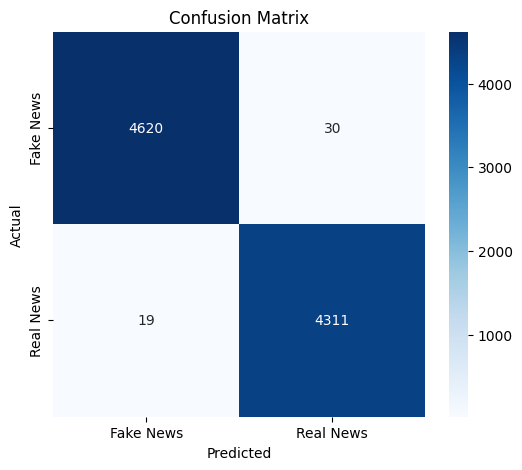

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake News', 'Real News'], yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


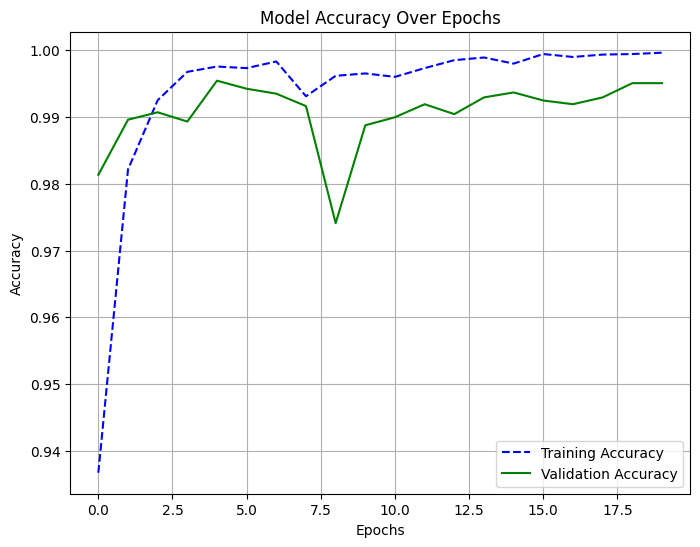

In [10]:
import matplotlib.pyplot as plt

# Create a figure for the accuracy plot
plt.figure(figsize=(8, 6))

# Plot the training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='--')

# Plot the validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')

# Add title and labels
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add legend to indicate training and validation accuracy
plt.legend(loc='lower right')

# Display the plot
plt.grid(True)
plt.show()


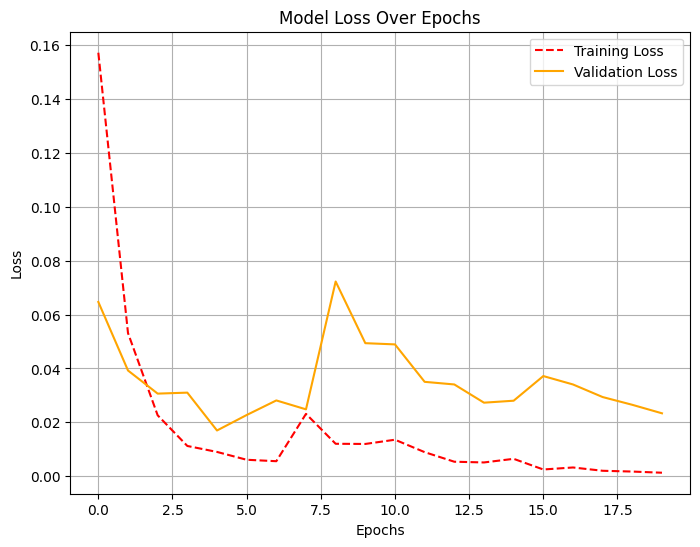

In [13]:
import matplotlib.pyplot as plt

# Create a figure for the loss plot
plt.figure(figsize=(8, 6))

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss', color='red', linestyle='--')

# Plot the validation loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

# Add title and labels
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add legend to indicate training and validation loss
plt.legend(loc='upper right')

# Display the plot
plt.grid(True)
plt.show()


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to preprocess and predict a single news article using the LSTM model
def predict_news_lstm(model, news_text):
    # Clean the input text
    review = re.sub('[^a-zA-Z]', ' ', news_text)
    review = review.lower().split()
    review = [ps.stem(word) for word in review if word not in stop_words]
    clean_news = ' '.join(review)
    
    # Convert the cleaned text to a sequence and pad it
    sequence = tokenizer.texts_to_sequences([clean_news])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)
    
    # Predict the class using the model
    prediction = model.predict(padded_sequence)
    return 'Real News' if prediction[0] > 0.5 else 'Fake News'

# Test the prediction function with a sample input
sample_news = data['text'].iloc[0]
print(f'Prediction (LSTM): {predict_news_lstm(model, sample_news)}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Prediction (LSTM): Real News
